In [2]:
import zipfile

# Replace 'your_file.zip' with the name of your uploaded file
with zipfile.ZipFile('/content/Potato___Early_blight.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# Making few constants to use it later
IMAGE_SIZE =256  # size of our images
BATCH_SIZE=32 # STANDARD batch size
CHANNELS=3 # RGB Channel

In [5]:
# Load the data into tensorflow daatset object
# tensorflow input pipeline
# here dataset is not dataframe-- this data structure here is  tf.data.Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  # directory name
    seed=123,  # just for predictability
    shuffle=True,  # Randomly shuffle the images
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # image size
    batch_size=BATCH_SIZE  # batch size to make batches of dataset
)

Found 2152 files belonging to 3 classes.


# Data Preprocessing !!

In [7]:
# Printing class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
# Exploring the dataset
# 1 batch=32 images
for image_batch, labels_batch in dataset.take(1):  # only first batch
    print(image_batch.shape)
    print(labels_batch.numpy())  # every element is a tensor so converting to numpy array

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


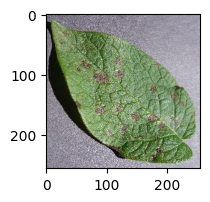

In [9]:
# Visualizing the image !
plt.figure(figsize=(2, 2))
for image_batch, labels_batch in dataset.take(1):  # only first batch
    # Getting only first image of first batch
    plt.imshow(image_batch[0].numpy().astype("uint8"))

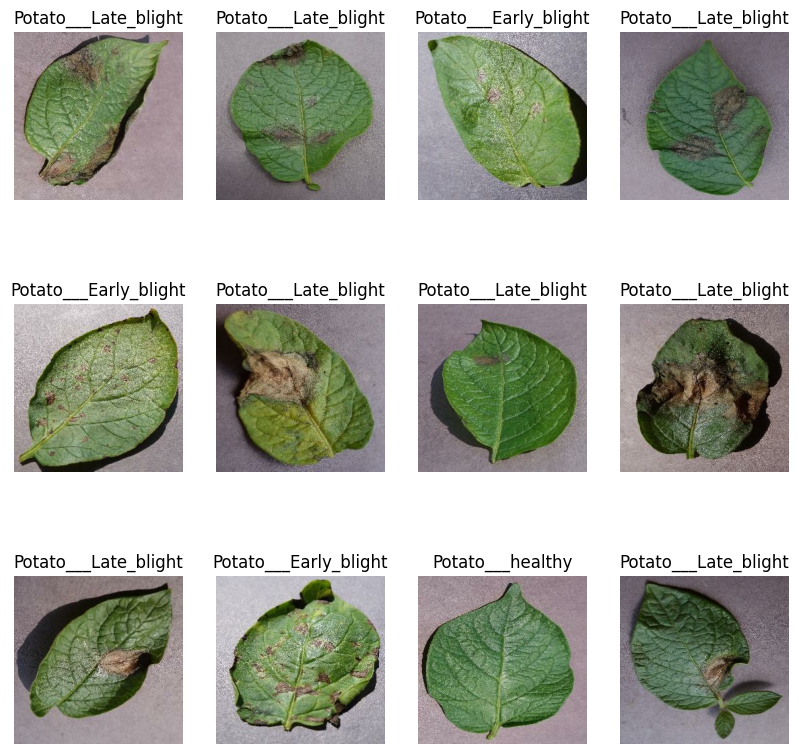

In [10]:
# Visualizing 12 images of batch 1 !
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):  # only first batch
    for i in range(12): # first 12 images
        ax = plt.subplot(3, 4, i + 1)  # subplot to arrange images together
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
# Every element in the dataset is a batch of 32 images
# there are 2152 images in the dataset
# 68*32=2176 (approx) so lengthof dataset is 68
len(dataset) # length of dataset-- this is number of batches !!!""

68

# Train test split

80% ==> Training

20% ==> 10% validation and 10% test

##### Validation is to test after each epoch

In [12]:
# We don't have train_test_split in tensorflow

In [13]:
train_size = 0.8
len(dataset)*train_size
# 54 batches for training dataset

54.400000000000006

In [14]:
# taking first 54 batches
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
# skipping first 54 batches batches
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
# validation dataset size
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
# first 6 batches for validation
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
# skipping first 6 batches from test_ds and making it for testing dataset
test_ds = test_ds.skip(6)
len(test_ds)

8

# Function for all that train_test_split

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # shuffle the dataset before train_test_split

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # getting batches for train, validate and test
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds  # all 3-- train, validation and test

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

# Cache, Shuffle, and Prefetch the Dataset
Cache: stores (or "caches") the dataset in memory (RAM) -- to avoid reloading again and again of dataset from disk.

Shuffle: Randomizes the order of your dataset’s examples.

Prefetch: loads the next batch of data in the background while the current batch is being processed.


In [24]:
# shuffle(1000)--buffer size-1000 to avoid patterns during training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Scaling the images to 0-1 and resizing each image to 256 by 256

In [25]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255)
])

# Data Augmentation
### To avoid overfitting ---creating more data sample by rotation of images

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # horz and vert flip of images
  tf.keras.layers.RandomRotation(0.2),
])

# MODEL BUILDING !

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3  # number of classes

# My CNN MODEL
model = models.Sequential([
    resize_and_rescale,  # Resize and rescale
    data_augmentation,
    #CNN Layers--- (use hit and trial and try more and more layers for better accuracy to know how many layers to be used)
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), # first layer--32 filters and 3,3 kernal
    layers.MaxPooling2D((2, 2)),  # pooling layer
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Classification dense network -- classification starts
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # 64 neurons in hidden layer
    layers.Dense(n_classes, activation='softmax'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
#Summary of model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # loss function
    metrics=['accuracy'] # metric to check accuracy
)

In [30]:
history = model.fit(
    train_ds, # training dataset--- x_train
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.4855 - loss: 0.9317 - val_accuracy: 0.6771 - val_loss: 0.7619
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7220 - loss: 0.6620 - val_accuracy: 0.8281 - val_loss: 0.3723
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8443 - loss: 0.3837 - val_accuracy: 0.8906 - val_loss: 0.2958
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8991 - loss: 0.2687 - val_accuracy: 0.8854 - val_loss: 0.2723
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8945 - loss: 0.2770 - val_accuracy: 0.9219 - val_loss: 0.2408
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9179 - loss: 0.2221 - val_accuracy: 0.8958 - val_loss: 0.2271
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9149 - loss: 0.2127 - val_accuracy: 0.9167 - val_loss: 0.2389
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9168 - loss: 0.2051 - val_accuracy: 0.9271 -

In [31]:
# Checking on testing dataset
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9882 - loss: 0.0294


In [34]:
history # history object of tf--> model.fit()

In [36]:
# Parameters which we used
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [40]:
# 50 epochs-- so 50 accuracies are there
len(history.history['accuracy'])

50

In [41]:
type(history.history['loss'])  #--it is a list

list

In [42]:
len(history.history['loss'])

50

In [43]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8901181817054749,
 0.5814375877380371,
 0.3573620319366455,
 0.2803737223148346,
 0.2470710724592209]

In [45]:
# Getting all 50 training accuracies
acc = history.history['accuracy']
# Getting all 50 validation accuracies
val_acc = history.history['val_accuracy']

# Getting all loses
loss = history.history['loss']
val_loss = history.history['val_loss']

## **Visualization of accuracies**

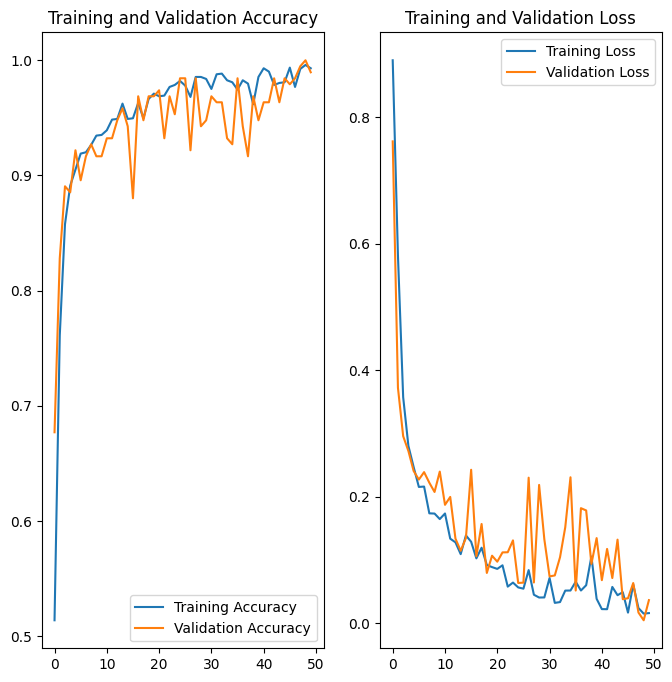

In [47]:
# Plotting Training vs Validation accuracies
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training vs Validation loss
plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Trying prediction on a sample image**

tf.Tensor(
[[[140. 129. 133.]
  [146. 135. 139.]
  [126. 115. 119.]
  ...
  [116. 104. 108.]
  [106.  94.  98.]
  [ 94.  82.  86.]]

 [[116. 105. 109.]
  [139. 128. 132.]
  [127. 116. 120.]
  ...
  [108.  96. 100.]
  [108.  96. 100.]
  [124. 112. 116.]]

 [[119. 108. 112.]
  [137. 126. 130.]
  [142. 131. 135.]
  ...
  [113. 101. 105.]
  [120. 108. 112.]
  [101.  89.  93.]]

 ...

 [[192. 187. 191.]
  [188. 183. 187.]
  [187. 182. 186.]
  ...
  [176. 168. 166.]
  [184. 176. 174.]
  [181. 173. 171.]]

 [[186. 181. 185.]
  [184. 179. 183.]
  [186. 181. 185.]
  ...
  [180. 172. 170.]
  [186. 178. 176.]
  [181. 173. 171.]]

 [[181. 176. 180.]
  [181. 176. 180.]
  [185. 180. 184.]
  ...
  [184. 176. 174.]
  [186. 178. 176.]
  [179. 171. 169.]]], shape=(256, 256, 3), dtype=float32)


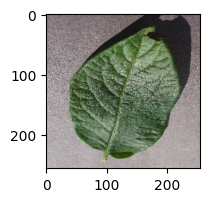

In [55]:
# first image
plt.figure(figsize=(2, 2))
for images_batch, labels_batch in test_ds.take(1):  # taking one batch
    first_image=images_batch[0] # this gives a tensor
    print(first_image)
    plt.imshow(first_image.numpy().astype('uint8'))

First image to predict:
Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted label: Potato___Early_blight


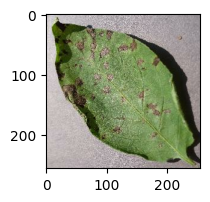

In [65]:
plt.figure(figsize=(2, 2))
for images_batch, labels_batch in test_ds.take(1):  # taking one batch

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy() # first label

    #Actual details
    print("First image to predict:")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])

    # Predicted label
    prediction = model.predict(images_batch)[0]  # for first image
    print("Predicted label:",class_names[np.argmax(prediction)]) # np.argmax to find the answer which got max value among 3 labels 0,1,2

In [69]:
# Function to know the predicted class and confidence accuracy value
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  #-- create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


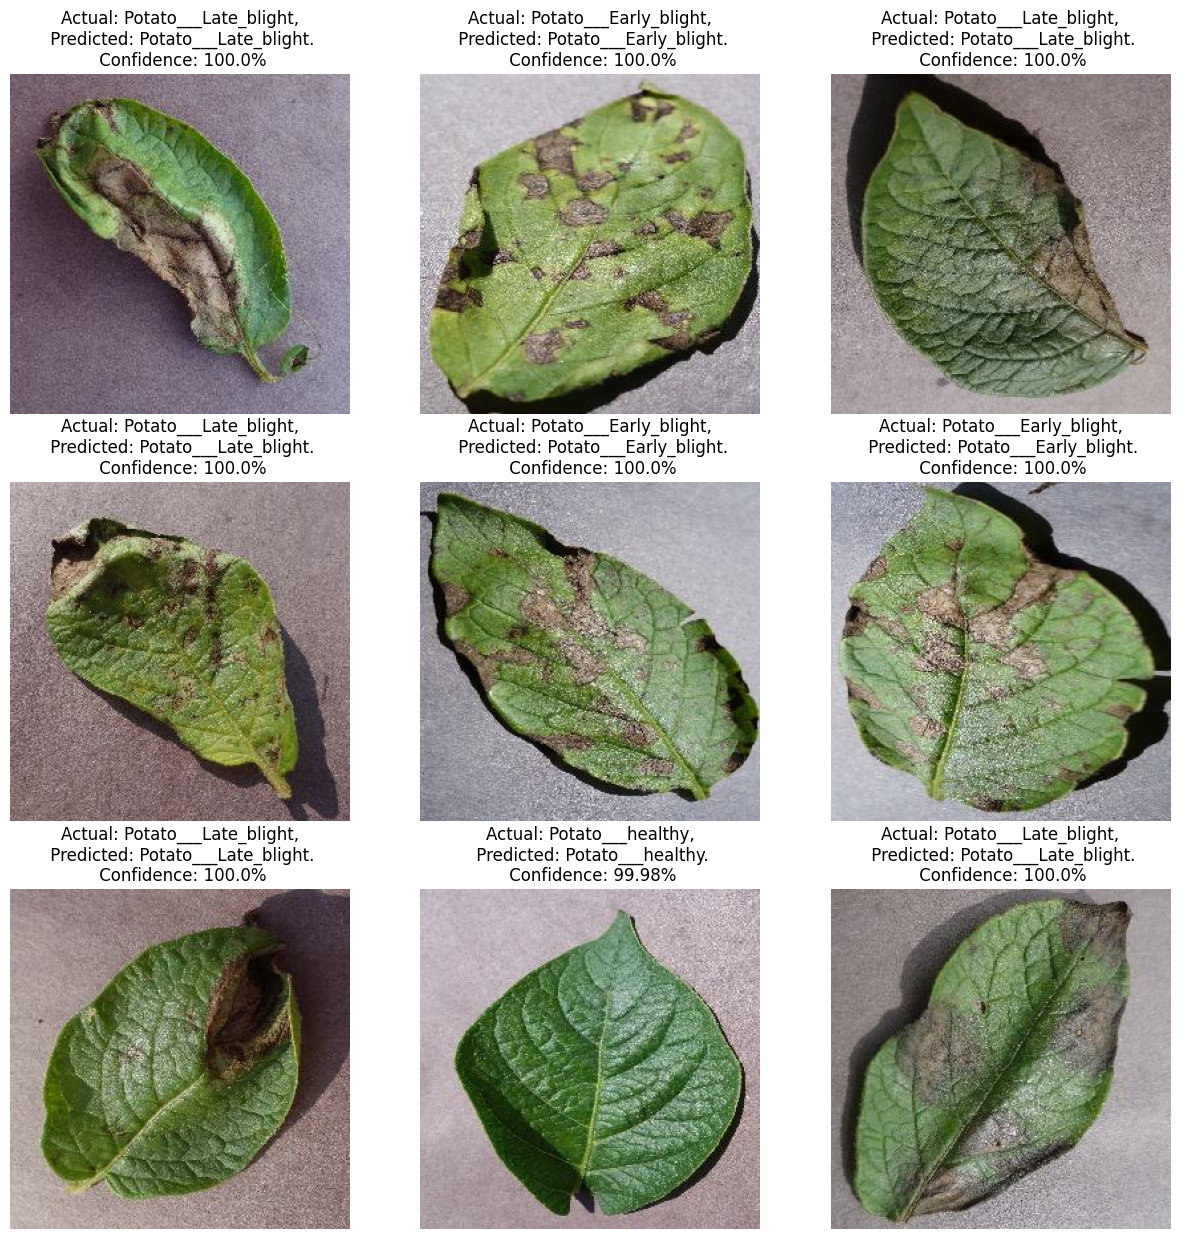

In [70]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1): # batch 1
    for i in range(9): # taking 9 images from batch 1
        ax = plt.subplot(3, 3, i + 1)
        # Plotting the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Getting the label and confidence value from the function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# **Saving the model**



In [73]:
# Try and change the parameters of model and save new versions in the directory.
# This automatically creates new model versions in the directory


# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [74]:
# model.save("../potatoes.h5")